In [1]:
import numpy as np
import numpy.random as rnd
import scipy.stats as st

In [2]:
from subalign import SubspaceAlignedClassifier, SemiSubspaceAlignedClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

In [3]:
%matplotlib inline
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set(style="whitegrid")

fS = 24
font = {'weight' : 'bold', 'size'   : fS}
matplotlib.rc('font', **font)

In [4]:
'''Generate data'''

# Dimensionality
D = 3

# Subspace dim
d = 2

# Number of classes
K = 2

# Sample sizes
N = (100, 100)
M = (100, 100)

if K == 1:
    
    if D == 2:

        muS = np.array([0, 1])
        muT = np.array([1, 0])
        SiS = np.array([[3, 0],[0, .1]])
        SiT = np.array([[3, 0],[0, .1]])

    elif D == 3:

        muS = np.array([-2, 1, 0])
        muT = np.array([1, 2, 0])
        SiS = np.array([[1, 0, 0],[0, 1, 0], [0, 0, 1]])/10
        SiT = np.array([[1, 0, 0],[0, 1, 0], [0, 0, 1]])/10

    pS = st.multivariate_normal(muS, SiS)
    pT = st.multivariate_normal(muT, SiT)

    X = pS.rvs(N[0])
    Y = np.zeros((N[0],))

    Z = pT.rvs(M[0])
    U = np.zeros((M[0],))

elif K == 2:

    if D == 2:

        muS0 = np.array([-3, -1])
        muS1 = np.array([2, 1])
        muT0 = np.array([1, 2])
        muT1 = np.array([1, -2])
        SiS0 = np.array([[2, 0],[0, 1]])/10
        SiS1 = np.array([[2, 0],[0, 1]])/10
        SiT0 = np.array([[1, 0.2],[0.2, 1]])/10
        SiT1 = np.array([[1, 0.2],[0.2, 1]])/10

    elif D == 3:

        muS0 = np.array([0, 0, 0])
        muS1 = np.array([1, 1, 1])
        muT0 = np.array([1, 0, 1])
        muT1 = np.array([0, 1, 0])
        SiS0 = np.array([[2, 0, 0],[0, 1, 0], [0, 0, 1]])/10
        SiS1 = np.array([[2, 0, 0],[0, 1, 0], [0, 0, 1]])/10
        SiT0 = np.array([[1, 0.4, 0],[0.4, 2, 0], [0, 0, 1]])/10
        SiT1 = np.array([[1, 0, 0.3],[0, 2, 0.5], [0.3, 0.5, 1]])/10

    pS0 = st.multivariate_normal(muS0, SiS0)
    pS1 = st.multivariate_normal(muS1, SiS1)
    pT0 = st.multivariate_normal(muT0, SiT0)
    pT1 = st.multivariate_normal(muT1, SiT1)

    X = np.concatenate((pS0.rvs(N[0]), pS1.rvs(N[1])), axis=0)
    Y = np.concatenate((np.zeros((N[0],)), np.ones(N[1],)), axis=0)

    Z = np.concatenate((pT0.rvs(M[0]), pT1.rvs(M[1])), axis=0)
    U = np.concatenate((np.zeros((M[0],)), np.ones(M[1],)), axis=0)
    
# Whiten data
# X = st.zscore(X)
# Z = st.zscore(Z)

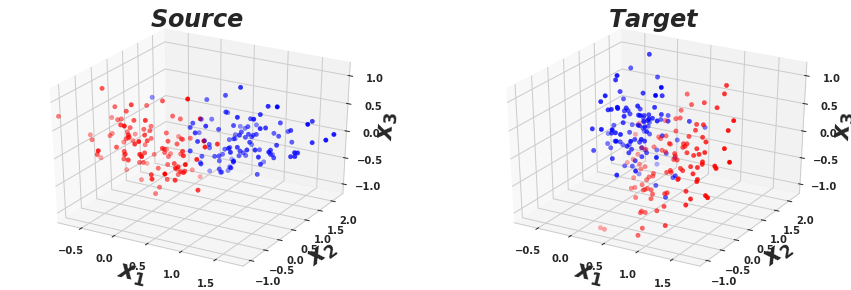

In [5]:
# Visualize data

fig = plt.figure(figsize=(15,5))

if D == 2:
        
    ax0 = fig.add_subplot(121)
    
    ax0.set_xlim([-4,4])
    ax0.set_ylim([-4,4])
    
    ax0.scatter(X[Y == 0, 0], X[Y == 0, 1], c='r')
    ax0.scatter(X[Y == 1, 0], X[Y == 1, 1], c='b')
    ax0.set_xlabel('$x_1$', fontsize=fS)
    ax0.set_ylabel('$x_2$', fontsize=fS)
    ax0.set_title('$Source$', fontsize=fS)

    ax1 = fig.add_subplot(122, sharex=ax0, sharey=ax0)
    ax1.scatter(Z[U == 0, 0], Z[U == 0, 1], c='r')
    ax1.scatter(Z[U == 1, 0], Z[U == 1, 1], c='b')
    ax1.set_xlabel('$x_1$', fontsize=fS)
    ax1.set_ylabel('$x_2$', fontsize=fS)
    ax1.set_title('$Target$', fontsize=fS);

elif D == 3:

    ax0 = fig.add_subplot(121, projection='3d')

    ax0.scatter(X[Y == 0, 0], X[Y == 0, 1], X[Y == 0, 2], c='r')
    ax0.scatter(X[Y == 1, 0], X[Y == 1, 1], X[Y == 0, 2], c='b')
    ax0.set_xlabel('$x_1$', fontsize=fS)
    ax0.set_ylabel('$x_2$', fontsize=fS)
    ax0.set_zlabel('$x_3$', fontsize=fS)
    ax0.set_title('$Source$', fontsize=fS)

    ax1 = fig.add_subplot(122, sharex=ax0, sharey=ax0, sharez=ax0, projection='3d')
    ax1.scatter(Z[U == 0, 0], Z[U == 0, 1], Z[U == 0, 1], c='r')
    ax1.scatter(Z[U == 1, 0], Z[U == 1, 1], Z[U == 0, 1], c='b')
    ax1.set_xlabel('$x_1$', fontsize=fS)
    ax1.set_ylabel('$x_2$', fontsize=fS)
    ax1.set_zlabel('$x_3$', fontsize=fS)
    ax1.set_title('$Target$', fontsize=fS);

In [6]:
# Estimate principal components
pcaX = PCA(n_components=d, whiten=True)
pcaZ = PCA(n_components=d, whiten=True)

pcaX.fit(X)
pcaZ.fit(Z)

# Domain-specific principal components
CX = pcaX.components_.T
CZ = pcaZ.components_.T

# Domain means
muX = pcaX.mean_
muZ = pcaZ.mean_

In [7]:
'''Find transformation'''

# Optimal linear transformation matrix
V = CX.T @ CZ

# Map source data onto source principal components
XC = X @ CX

# Map source data onto source principal components and align to target components
XV = X @ CX @ V

# Map target data onto target principal components
ZC = Z @ CZ

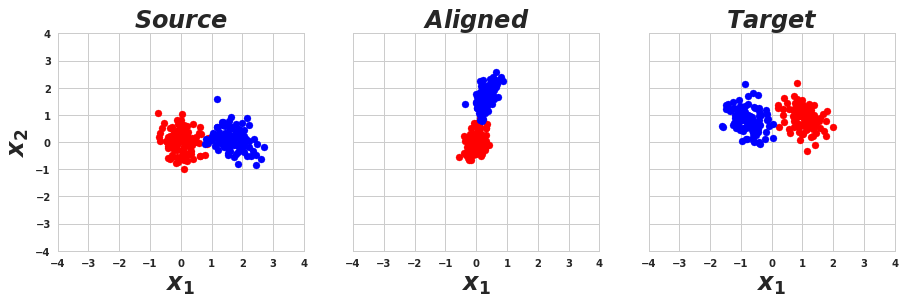

In [8]:
# Visualize data

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15,4))

ax[0].set_xlim([-4,4])
ax[0].set_ylim([-4,4])

ax[0].scatter(XC[Y == 0, 0], XC[Y == 0, 1], c='r')
ax[0].scatter(XC[Y == 1, 0], XC[Y == 1, 1], c='b')
ax[0].set_xlabel('$x_1$', fontsize=fS)
ax[0].set_ylabel('$x_2$', fontsize=fS)
ax[0].set_title('$Source$', fontsize=fS)

ax[1].scatter(XV[Y == 0, 0], XV[Y == 0, 1], c='r')
ax[1].scatter(XV[Y == 1, 0], XV[Y == 1, 1], c='b')
ax[1].set_xlabel('$x_1$', fontsize=fS)
ax[1].set_title('$Aligned$', fontsize=fS);

ax[2].scatter(ZC[U == 0, 0], ZC[U == 0, 1], c='r')
ax[2].scatter(ZC[U == 1, 0], ZC[U == 1, 1], c='b')
ax[2].set_xlabel('$x_1$', fontsize=fS)
ax[2].set_title('$Target$', fontsize=fS);

fig.savefig('viz/test_subalign01.png', bbox_inches='tight', padding=None)

In [9]:
# Estimate class-specific components

muXk = np.zeros((K, d))
muXk = np.zeros((K, d))
CXk = np.zeros((K, D, d))
CZk = np.zeros((K, D, d))
Vk = np.zeros((K, d, d))

for k in range(K):
    
    # Extract source data from k-th class
    Xk = X[Y == k, :]
#     Xk = st.zscore(Xk)
    
    # Extract target data from k-th class
    Zk = Z[U == k, :]
#     Zk = st.zscore(Zk)
    
    # Extract source class-specific components
    pcaXk = PCA(n_components=d)
    CXk[k] = pcaXk.fit(Xk).components_.T
    
    # Extract target class-specific components
    pcaZk = PCA(n_components=d)
    CZk[k] = pcaZk.fit(Zk).components_.T 
    
    # Find specific linear transformation matrix
    Vk[k] = CXk[k].T @ CZk[k]

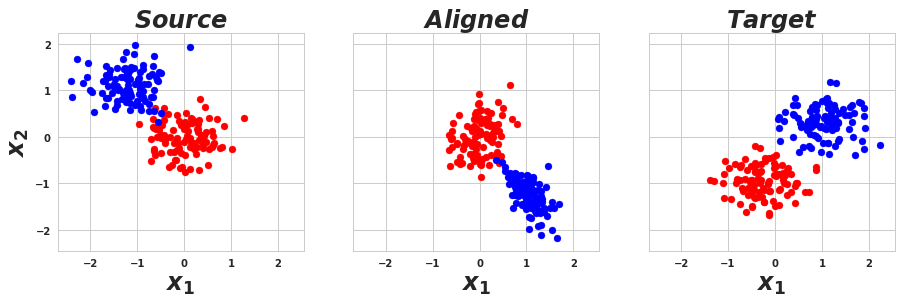

In [10]:
# Visualize data

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15,4))

XC0 = X[Y == 0, :] @ CXk[0]
XC1 = X[Y == 1, :] @ CXk[1]

XV0 = X[Y == 0, :] @ CXk[0] @ Vk[0]
XV1 = X[Y == 1, :] @ CXk[1] @ Vk[1]

ZC0 = Z[U == 0, :] @ CZk[0]
ZC1 = Z[U == 1, :] @ CZk[1]

ax[0].scatter(XC0[:, 0], XC0[:, 1], c='r')
ax[0].scatter(XC1[:, 0], XC1[:, 1], c='b')
ax[0].set_xlabel('$x_1$', fontsize=fS)
ax[0].set_ylabel('$x_2$', fontsize=fS)
ax[0].set_title('$Source$', fontsize=fS)

ax[1].scatter(XV0[:, 0], XV0[:, 1], c='r')
ax[1].scatter(XV1[:, 0], XV1[:, 1], c='b')
ax[1].set_xlabel('$x_1$', fontsize=fS)
ax[1].set_title('$Aligned$', fontsize=fS);

ax[2].scatter(ZC0[:, 0], ZC0[:, 1], c='r')
ax[2].scatter(ZC1[:, 0], ZC1[:, 1], c='b')
ax[2].set_xlabel('$x_1$', fontsize=fS)
ax[2].set_title('$Target$', fontsize=fS);

fig.savefig('viz/test_semisubalign01.png', bbox_inches='tight', padding=None)